# Unzip file from datasets.

In [9]:
from py7zr import SevenZipFile

with SevenZipFile("datasets/CHIvTOR.7z", "r") as zip:
    json_file = zip.getnames()[0]
    zip.extractall(path="data/")

# Read json data

In [10]:
import json

f = open(f"data/{json_file}")
data = json.load(f)
f.close()

# Prepare training and test data

In [11]:
from model import Player
from random import choice

events = data["events"]

# extracting player ids of the home team
team_id = events[0]["home"]["teamid"]
roster = {x["playerid"]: (f"{x['firstname']} {x['lastname']}", x["jersey"]) for x in events[0]["home"]["players"]}
# only considering players that are starting the game
starting = {}
for player in events[0]["moments"][0][5]:
    if player[1] in roster.keys():
        starting.update({f"{player[1]}": Player(player[1], roster[player[1]][0], roster[player[1]][1])})

# selecting a random player as the expert
expert_player = choice(list(starting.keys()))
expert = {"train": [], "test": []}

# the rest learn from the expert
learners = {}

print("Starting Team:")
for pid in starting.keys():
    print(starting[pid])
    if pid == expert_player:
        continue
    learners.update({f"{pid}": {"train": [], "test": []}})

print(f"\n{starting[expert_player]} is our expert for this run.")

for event in events:
    moments = event["moments"]
    # not considering time outs or quarter breaks
    if len(moments) == 0:
        continue
    # ignoring free throws
    if moments[0][3] is None:
        continue
    quarter, ball_x = moments[0][0], moments[0][5][0][2]
    # only considering defensive plays (using ball position)
    # first half
    if quarter < 3 and ball_x < 50:
        continue
    # second half
    if quarter > 2 and ball_x > 50:
        continue
    # player positions for the first half (2 quarters) will be used for training and last quarter for testing
    if quarter <= 2:
        for moment in moments:
            player_pos = moment[5]
            flag = []
            _, _, bx, by, _ = player_pos[0]
            for tid, pid, px, py, pz in player_pos[1:]:
                if tid != team_id:
                    continue
                if str(pid) in learners.keys():
                    learners[str(pid)]["train"].append([bx, by, px, py])
                    flag.append(str(pid))
                if str(pid) == expert_player:
                    expert["train"].append([px, py])
                    flag.append(str(pid))
            # only consider plays where all of them are playing (so that they can match with the expert)
            if len(flag) != 5:
                for pid in flag:
                    if expert_player == pid:
                        expert["train"].pop()
                    else:
                        learners[pid]["train"].pop()
    else:
        for moment in moments:
            player_pos = moment[5]
            flag = []
            _, _, bx, by, _ = player_pos[0]
            for tid, pid, px, py, pz in player_pos[1:]:
                if tid != team_id:
                    continue
                if str(pid) in learners.keys():
                    learners[str(pid)]["test"].append([bx, by, px, py])
                    flag.append(str(pid))
                if str(pid) == expert_player:
                    expert["test"].append([px, py])
                    flag.append(str(pid))
            # only consider plays where all of them are playing (so that they can match with the expert)
            if len(flag) != 5:
                for pid in flag:
                    if expert_player == pid:
                        expert["test"].pop()
                    else:
                        learners[pid]["test"].pop()

Starting Team:
Luis Scola #4
DeMarre Carroll #5
Kyle Lowry #7
DeMar DeRozan #10
Jonas Valanciunas #17

DeMarre Carroll #5 is our expert for this run.


# Defining models

In [34]:
from model import Network, DLoss, VLoss
from torch import as_tensor, nn, optim, split

# setting hyper parameters
learning_rate, epochs, batch_size = 0.1, 150, 50

states, tests = {}, {}
actors, discriminators, values = {}, {}, {}
act_opts, dis_opts, val_opts = {}, {}, {}

act_criterion = nn.MSELoss()
dis_criterion = DLoss()
val_criterion = VLoss()

x_expert, y_expert = split(as_tensor(expert["train"]).float(), batch_size), as_tensor(expert["test"]).float()

for pid in learners.keys():
    states[pid], tests[pid] = as_tensor(learners[pid]["train"]).float(), as_tensor(learners[pid]["test"]).float()
    actors[pid] = Network(4, 2)
    discriminators[pid] = Network(6, 1)
    values[pid] = Network(2, 2)
    act_opts[pid] = optim.Adadelta(actors[pid].parameters(), lr = learning_rate)
    dis_opts[pid] = optim.Adadelta(discriminators[pid].parameters(), lr = learning_rate)
    val_opts[pid] = optim.Adadelta(values[pid].parameters(), lr = learning_rate)

In [35]:
from model import Network, DLoss, VLoss
from torch import from_numpy, sqrt, cat
import numpy as np
from math import ceil
import time

chk = time.time()
losses = {}
epochs_d = []

for epoch in range(epochs):
    epochs_d.append(epoch)
    if epoch % 10 == 0:
        print(f"\nEpoch {epoch}:")
    # training
    for pid in learners.keys():
        player_states = split(states[pid], batch_size)
        # train actor
        for i, batch in enumerate(player_states):
            act_opts[pid].zero_grad()
            dis_opts[pid].zero_grad()
            val_opts[pid].zero_grad()
            # forward pass
            learner_action = actors[pid](batch) + batch[:, 2:]
            expert_action = x_expert[i]
            val_action = values[pid](batch[:, 2:])
            score = discriminators[pid](cat((batch, learner_action), 1))
            # compute Loss
            act_loss = sqrt(act_criterion(learner_action, expert_action))
            dis_loss = dis_criterion(len(batch), score, learner_action, expert_action)
            val_loss = val_criterion(val_action)
            # backward pass
            act_loss.backward(retain_graph=True)
            dis_loss.backward()
            val_loss.backward()
            act_opts[pid].step()
            dis_opts[pid].step()
            val_opts[pid].step()
        
        # testing
        actors[pid].eval()
        y_action = actors[pid](tests[pid]) + tests[pid][:, 2:]
        train_loss = sqrt(act_criterion(y_action, y_expert)).item()
        
        # for plotting
        if pid in losses.keys():
            losses[pid].append(train_loss)
        else:
            losses[pid] = [train_loss]
        
        if epoch % 10 == 0:
            print(f"Player: {starting[pid]}; Train Loss: {round(train_loss, 4)}")
print(f"Time taken: {round(time.time() - chk, 4)} seconds.")


Epoch 0:
Player: Luis Scola #4; Train Loss: 14.5088
Player: Kyle Lowry #7; Train Loss: 15.1776
Player: DeMar DeRozan #10; Train Loss: 17.1512
Player: Jonas Valanciunas #17; Train Loss: 13.2207

Epoch 10:
Player: Luis Scola #4; Train Loss: 14.4669
Player: Kyle Lowry #7; Train Loss: 15.1808
Player: DeMar DeRozan #10; Train Loss: 16.8702
Player: Jonas Valanciunas #17; Train Loss: 13.1864

Epoch 20:
Player: Luis Scola #4; Train Loss: 14.4613
Player: Kyle Lowry #7; Train Loss: 15.1794
Player: DeMar DeRozan #10; Train Loss: 16.8436
Player: Jonas Valanciunas #17; Train Loss: 13.1581

Epoch 30:
Player: Luis Scola #4; Train Loss: 14.4606
Player: Kyle Lowry #7; Train Loss: 15.1783
Player: DeMar DeRozan #10; Train Loss: 16.8549
Player: Jonas Valanciunas #17; Train Loss: 13.1485

Epoch 40:
Player: Luis Scola #4; Train Loss: 14.4509
Player: Kyle Lowry #7; Train Loss: 15.1776
Player: DeMar DeRozan #10; Train Loss: 16.8464
Player: Jonas Valanciunas #17; Train Loss: 13.144

Epoch 50:
Player: Luis Sco

# Plotting training results

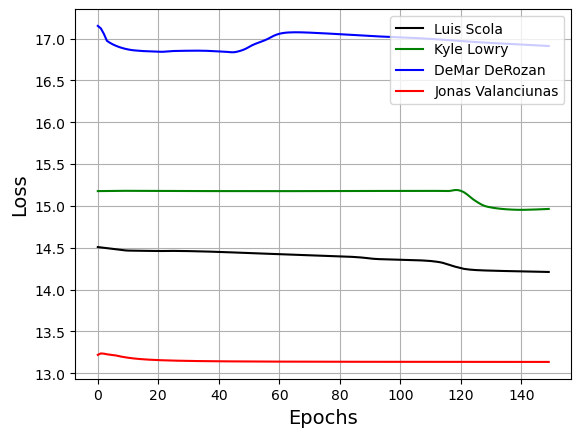

In [36]:
import matplotlib.pyplot as plt

colors = ["red", "blue", "green", "black"]

for pid in learners.keys():
    plt.plot(epochs_d, losses[pid], color=colors.pop(), label=starting[pid].name)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()